### Basic stats and probability reminders

In [36]:
from IPython.display import Math, display
from IPython.display import Image
from IPython.core.display import HTML 


In [21]:
# expected value
display(Math('E(x)=\mu'))

<IPython.core.display.Math object>

Let x be a random variable with a finite nuber of finite outcomes x1, x2 ... xk occring with probabilities p1,p2,...pk. The E(x) expected value of x is defined as:

In [11]:
display(Math('E(x)=\sum x_{i} p_{i}'))

<IPython.core.display.Math object>

The outcomes can be {1,2,3,4,5,6}The E(x) expected value of x is:

In [18]:
display(Math('1\\frac{1}{6} + 2\\frac{1}{6} + 3\\frac{1}{6} + 4\\frac{1}{6} + 5\\frac{1}{6} + 6\\frac{1}{6} = 3.5'))

<IPython.core.display.Math object>

The roulette game consists of a wheel with 38 numbered pockets. Let x represent the outcome of 1$ on a single number.

<span class="tex2jax_ignore">E(x) = $1*37/38 + $35*1/38 = $-0.0526</span>

In [30]:
# Variance is always positive. The variance of an x 
# random variable is the expected value of the squared deviations of variables from the mean
display(Math('\\text{Variance }\sigma^²=[(x-\mu)²]'))

<IPython.core.display.Math object>

In [33]:
display(Math('\\text{Covariance } Cov(x,y)= E[(x-\mu)(x-\mu)]'))

<IPython.core.display.Math object>

There is one issue when dealing with covariance: <br>
    <li>It is a dimensional measure
    <li>It is not normalized so it is hard to compare datasets with large differences in spread

The graph below shows why covariance wouldn't be a fit to compare the evolution of the following stock prices. Eventhough the TSLA stock was very volatile, it is not visible because the absolute value of the most expensive stock (MSFT) erases the amplitude of TSLA, relatively to MSFT's price variations.

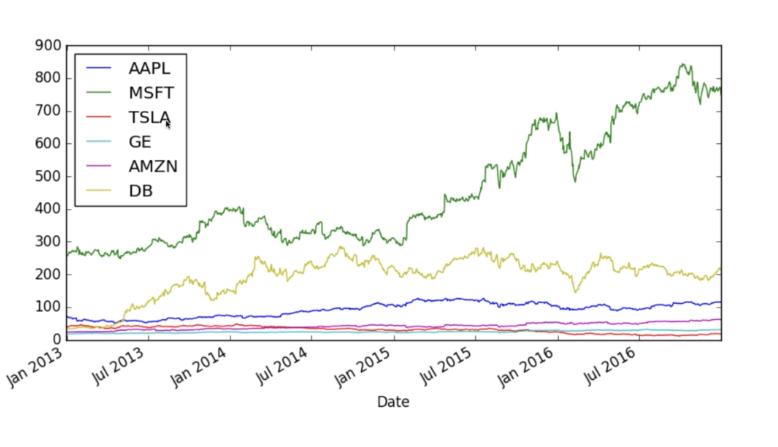

In [40]:
PATH = "/home/nesov/Desktop/"
Image(filename = PATH + "stocks_var.png", width=800, height=600)

Correlation is a response to this non-comparability. It is a dimensionless measure of how two random variables vary together.

In [45]:
display(Math('\\text{Correlation } \delta(x,y)= E[(\\frac{(x-\mu)(y-\mu)}{\sigma_x\sigma_y})]'))

<IPython.core.display.Math object>

### Markowitz-Model: Portfolio optimization model

It assists in the selection of the most **efficient** portfolio by considering various possible portfolios of the given securities based on expected return (mean) and risk (variance).<br>
What does **"efficient"** mean?

<li>It assumes normality
<li>Investors are risk-averse: investors will take on more risk if they expect more returns

<br>
    
The **"efficient**" portfolio is the portfolio that has the highest reward for a given level of risk or the lowest risk for a given return

### Markowitz model implementation

In [4]:
import numpy as np
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as optimization

# stock we are going to handle
stocks = ['AAPL', 'WMT', 'TSLA', 'AMZN', 'DB']
start_date = '2010-01-01'
end_date = '2017-01-01'

def download_data():
    stock_data = {}
    
    for stock in stocks:
        ticker = yf.Ticker(stock)
        stock_data[stock] = ticker.history(start=start_date, end=end_date)['Close']
        
    return pd.DataFrame(stock_data)
        
    

In [5]:
print(download_data())

                 AAPL        WMT       TSLA        AMZN         DB
Date                                                              
2009-12-31   6.452590  40.374466        NaN  134.520004  57.167488
2010-01-04   6.553025  40.963634        NaN  133.899994  59.037865
2010-01-05   6.564355  40.555740        NaN  134.690002  60.166542
2010-01-06   6.459941  40.465096        NaN  132.250000  59.126541
2010-01-07   6.447999  40.487755        NaN  130.000000  59.795696
...               ...        ...        ...         ...        ...
2016-12-23  27.419538  62.836655  42.667999  760.590027  17.915533
2016-12-27  27.593679  62.981236  43.905998  771.400024  17.665506
2016-12-28  27.476019  62.628815  43.948002  772.130005  17.232763
2016-12-29  27.468952  62.583652  42.936001  765.150024  17.136599
2016-12-30  27.254816  62.457153  42.737999  749.869995  17.405859

[1763 rows x 5 columns]


**if yfinance json decode error:**

<li>pip uninstall yfinance
<li>pip uninstall pandas-datareader
<li>pip install yfinance --upgrade --no-cache-dir
<li>pip install pandas-datareader